In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dataset = pd.read_csv("QVI_data.csv")

In [7]:
dataset.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,17-10-2018,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,16-09-2018,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,07-03-2019,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,08-03-2019,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,02-11-2018,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


# Preprocess the data

In [14]:
# Convert DATE column to datetime format
dataset["DATE"] = pd.to_datetime(dataset["DATE"], format="%d-%m-%Y")

# Extract year and month for aggregation
dataset["YearMonth"] = dataset["DATE"].dt.to_period("M")

In [131]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
 12  YearMonth         264834 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(6), object(4), peri

In [16]:
# Aggregate data by store and month
monthly_sales = dataset.groupby(["STORE_NBR", "YearMonth"]).agg(
    total_sales=("TOT_SALES", "sum"),               # Total revenue
    total_customers=("LYLTY_CARD_NBR", "nunique"),  # Unique customers per month
    total_transactions=("TXN_ID", "nunique")        # Total transactions per month
).reset_index()

# Calculate transactions per customer
monthly_sales["avg_txn_per_customer"] = (
    monthly_sales["total_transactions"] / monthly_sales["total_customers"]
)

In [49]:
monthly_sales.head()

,STORE_NBR,YearMonth,total_sales,total_customers,total_transactions,avg_txn_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


# Define a Function to Select Control Stores

In [35]:
from scipy.stats import pearsonr

In [44]:
def find_control_store(trial_store, data):
    """
    Finds the most similar control store for a given trial store based on total sales.
    Uses Pearson correlation.
    """
    trial_data = data[data["STORE_NBR"] == trial_store].set_index("YearMonth")

    best_correlation = -1
    best_store = None

    for store in data["STORE_NBR"].unique():
        if store == trial_store:
            continue  

        control_data = data[data["STORE_NBR"] == store].set_index("YearMonth")

        # Merge data on YearMonth to align time periods
        merged_data = trial_data[["total_sales"]].merge(
            control_data[["total_sales"]],
            left_index=True, right_index=True,
            suffixes=("_trial", "_control")
        )

        # Skip stores with too little data
        if len(merged_data) < 2:
            continue

        # Check if any store has constant sales (no variation)
        if np.all(merged_data["total_sales_trial"] == merged_data["total_sales_trial"].iloc[0]) or \
           np.all(merged_data["total_sales_control"] == merged_data["total_sales_control"].iloc[0]):
            continue

        # Calculate Pearson correlation
        correlation, _ = pearsonr(merged_data["total_sales_trial"], merged_data["total_sales_control"])

        # Update best match
        if correlation > best_correlation:
            best_correlation = correlation
            best_store = store

    return best_store

In [92]:
# Example: Find a control store for store 77
trial_store = 77
control_store = find_control_store(trial_store, monthly_sales)
print(f"Control store for trial store {trial_store}: {control_store}")

Control store for trial store 77: 11


# Compare Trial vs Control Store Sales

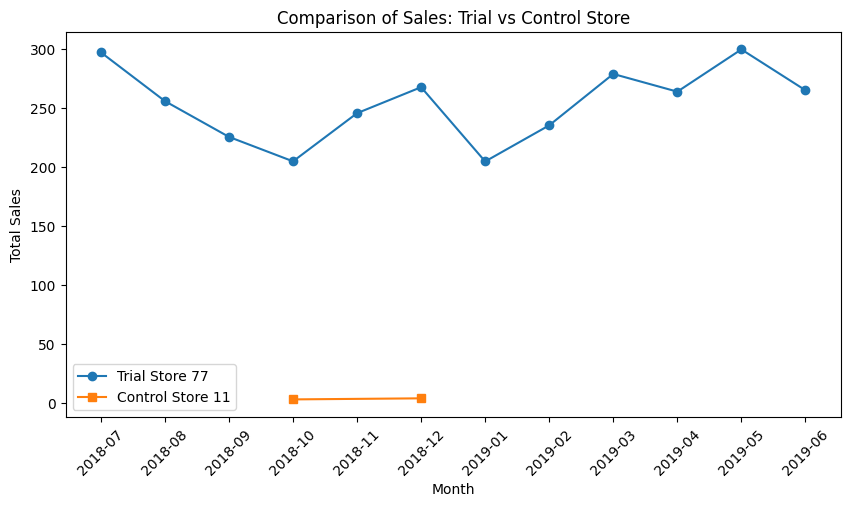

In [55]:
def plot_trial_vs_control(trial_store, control_store, data):
    """
    Plots total sales for trial store vs control store over time.
    """
    trial_data = data[data["STORE_NBR"] == trial_store].copy()
    control_data = data[data["STORE_NBR"] == control_store].copy()

    # Convert 'YearMonth' to string for plotting
    trial_data["YearMonth"] = trial_data["YearMonth"].astype(str)
    control_data["YearMonth"] = control_data["YearMonth"].astype(str)

    plt.figure(figsize=(10, 5))
    plt.plot(trial_data["YearMonth"], trial_data["total_sales"], label=f"Trial Store {trial_store}", marker='o')
    plt.plot(control_data["YearMonth"], control_data["total_sales"], label=f"Control Store {control_store}", marker='s')
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.title("Comparison of Sales: Trial vs Control Store")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
    
# Analyze sales drivers
plot_trial_vs_control(trial_store, control_store, monthly_sales)

# Test If Sales Are Significantly Different

In [110]:
# Use a T-test to compare sales between stores

def compare_sales(trial_store, control_store, data, start_month, end_month):
    """
    Performs a t-test to compare sales between trial and control stores during the trial period.
    """

    # Ensure 'YearMonth' is string type for comparison
    data["YearMonth"] = data["YearMonth"].astype(str)

    trial_sales = data[
        (data["STORE_NBR"] == trial_store) & 
        (data["YearMonth"] >= start_month) & 
        (data["YearMonth"] <= end_month)
    ]["total_sales"]

    control_sales = data[
        (data["STORE_NBR"] == control_store) & 
        (data["YearMonth"] >= start_month) & 
        (data["YearMonth"] <= end_month)
    ]["total_sales"]

    # Check if we have enough data points
    if len(trial_sales) < 2 or len(control_sales) < 2:
        print("⚠️ Not enough data points for t-test. Need at least 2 observations per group.")
        return

    # Perform t-test
    stat, p_value = ttest_ind(trial_sales, control_sales, equal_var=False)

    print(f"T-test results: t-statistic = {stat:.2f}, p-value = {p_value:.4f}")
    
    if p_value < 0.05:
        print("🚀 Significant difference detected in sales during the trial period.")
    else:
        print("❌ No significant difference in sales.")

In [112]:
# Example: Check sales for January to March 2019
trial_store = 77  # Example trial store number
control_store = 86  # Example control store number
compare_sales(trial_store, control_store, monthly_sales, "2019-01", "2019-03")

T-test results: t-statistic = -11.84, p-value = 0.0024
🚀 Significant difference detected in sales during the trial period.


# Find the Cause of Change

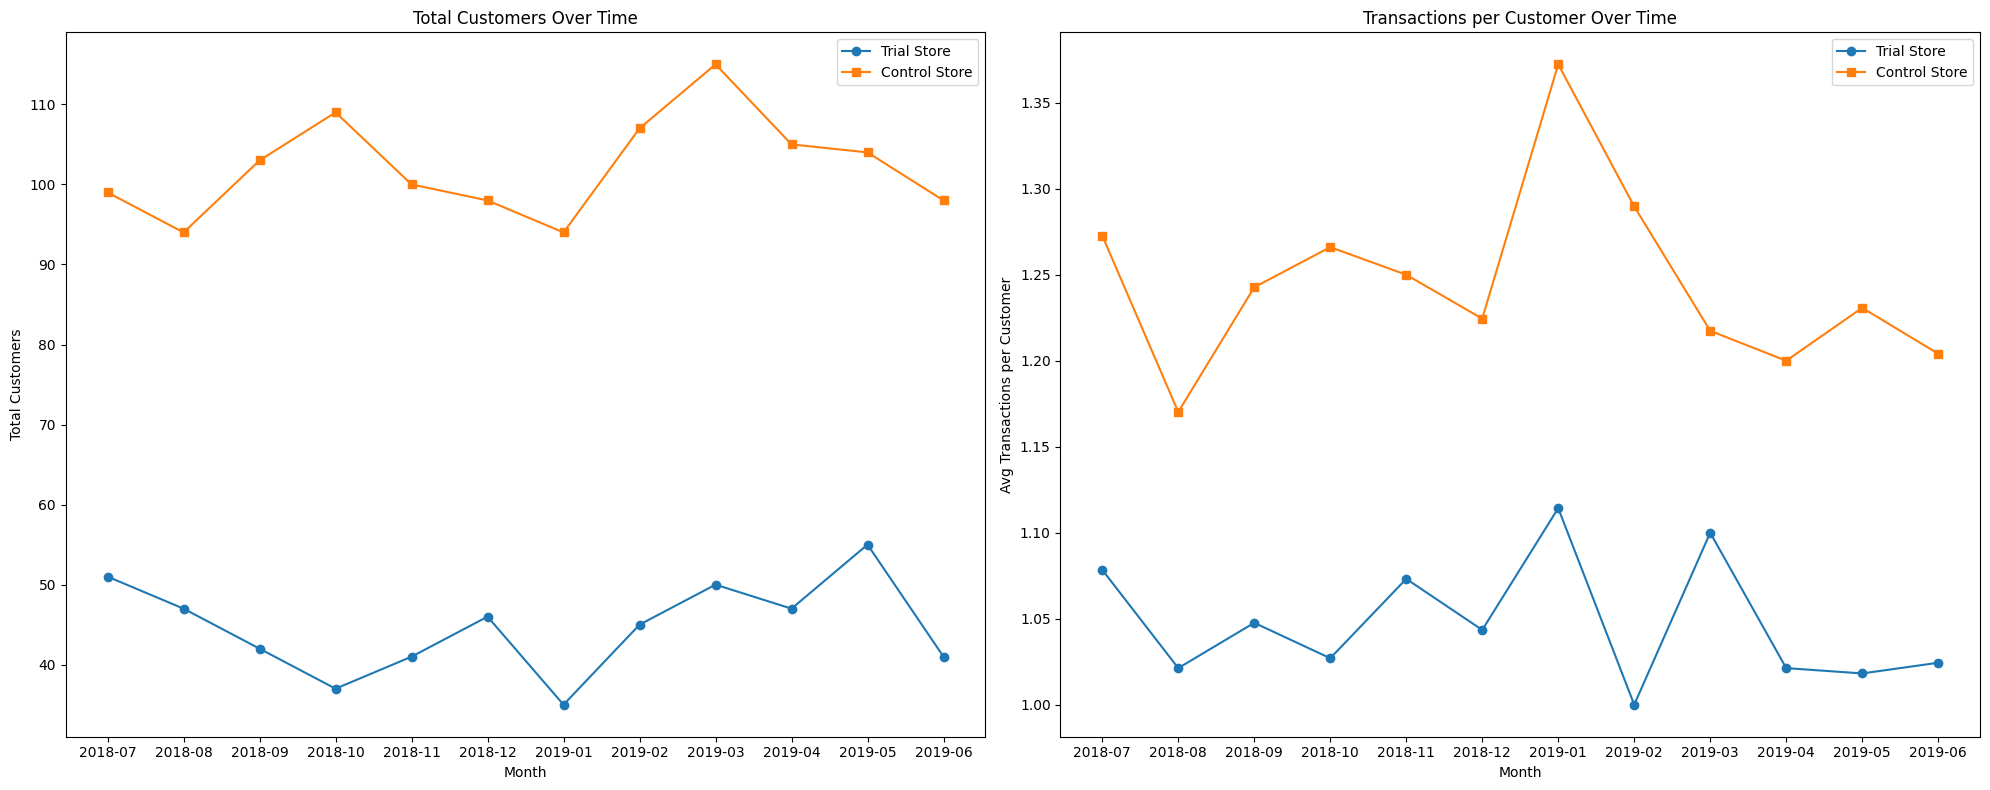

In [129]:
def analyze_sales_drivers(trial_store, control_store, data):
    """
    Compare customer count and transactions per customer to find the sales driver.
    """
    trial_data = data[data["STORE_NBR"] == trial_store].set_index("YearMonth")
    control_data = data[data["STORE_NBR"] == control_store].set_index("YearMonth")

    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.plot(trial_data["total_customers"], label="Trial Store", marker='o')
    plt.plot(control_data["total_customers"], label="Control Store", marker='s')
    plt.xlabel("Month")
    plt.ylabel("Total Customers")
    plt.title("Total Customers Over Time")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(trial_data["avg_txn_per_customer"], label="Trial Store", marker='o')
    plt.plot(control_data["avg_txn_per_customer"], label="Control Store", marker='s')
    plt.xlabel("Month")
    plt.ylabel("Avg Transactions per Customer")
    plt.title("Transactions per Customer Over Time")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Analyze sales drivers
analyze_sales_drivers(trial_store, control_store, monthly_sales)